In [1]:
# CONDA: tnt
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.width', 1000)
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import helpers as h
reload(h)

<module 'helpers' from '/Users/koenraijer/Documents/Universiteit/Student-assistent/IP-TNT/Data/helpers.py'>

In [61]:
reload(h)

empatica_df = pd.read_csv('output/empatica_combined_raw.csv')
inquisit_df = pd.read_csv('output/inquisit_combined_raw.csv')

merged_df = h.merge_inquisit_empatica(empatica_df, inquisit_df)

merged_df.to_csv('output/empatica_inquisit_merged.csv', index=False)

In [58]:
empatica_df['time'] = empatica_df['time'].astype('datetime64[ns]').astype(int) / 10**9
inquisit_df['time'] = inquisit_df['time'].astype('datetime64[ns]').astype(int) / 10**9

# Sort both DataFrames by the 'time' column
empatica_df = empatica_df.sort_values('time')
inquisit_df = inquisit_df.sort_values('time')

# Merge the two DataFrames using merge_asof on the 'time' column and rename the 'time' column from inquisit_df to 'time_y'
merged_df = pd.merge_asof(empatica_df, inquisit_df[['time', 'response']].rename(columns={'time': 'time_y'}), left_on='time', right_on='time_y', direction='nearest')

merged_df['time'] = pd.to_datetime(merged_df['time'], unit='s')
merged_df['time_y'] = pd.to_datetime(merged_df['time_y'], unit='s')

# Calculate the time differences and store them in a new 'time_diff' column
merged_df['time_diff'] = (merged_df['time'] - merged_df['time_y']).abs()

# Add a new 'response' column to merged_df containing the response value only if the time difference is less than or equal to 0.25 seconds
merged_df['new_response'] = merged_df.apply(lambda row: row['response'] if row['time_diff'] <= pd.Timedelta(seconds=0.25) else 0, axis=1)

# Drop the unnecessary 'time_y' and 'response' columns
merged_df.drop(columns=['time_y', 'response'], inplace=True)

# Rename the 'new_response' column to 'response'
merged_df.rename(columns={'new_response': 'response'}, inplace=True)

# If the response was 3 or 80, set it to 1; if the response was 4 or 81, set it to 2.
merged_df['response'] = merged_df['response'].apply(lambda x: 1 if x in [3, 80] else 2 if x in [4, 81] else 0)

# Add a new column named 'intrusion' containing 1 if the response is 1 or 2, and 0 otherwise 
merged_df['intrusion'] = merged_df['response'].apply(lambda x: 1 if x in [1, 2] else 0)

         acc_x      acc_y      acc_z         hr   temp       eda         bvp                          time                 time_diff  response  intrusion
0    -9.285870  42.936198  43.831382  80.814292  26.45  0.026906    4.118854 1970-01-01 00:00:01.679486718 0 days 00:00:00.000023731         0          0
1    -5.732297  46.785212  43.438090  90.170361  26.45  0.026906  -26.130442 1970-01-01 00:00:01.679486718 0 days 00:00:00.000023731         0          0
2    -2.237697  43.976816  44.922013  92.425688  26.45  0.028188   14.419979 1970-01-01 00:00:01.679486718 0 days 00:00:00.000023731         0          0
3    -4.673917  44.903054  45.332522  89.400447  26.45  0.028188   10.727726 1970-01-01 00:00:01.679486718 0 days 00:00:00.000023731         0          0
4    -7.575088  44.367411  43.601637  84.108272  26.13  0.026906  -17.376916 1970-01-01 00:00:01.679486719 0 days 00:00:00.000023730         0          0
5    -6.491830  46.376364  41.866929  79.568219  26.13  0.026906   -0.065494

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>], dtype=object)

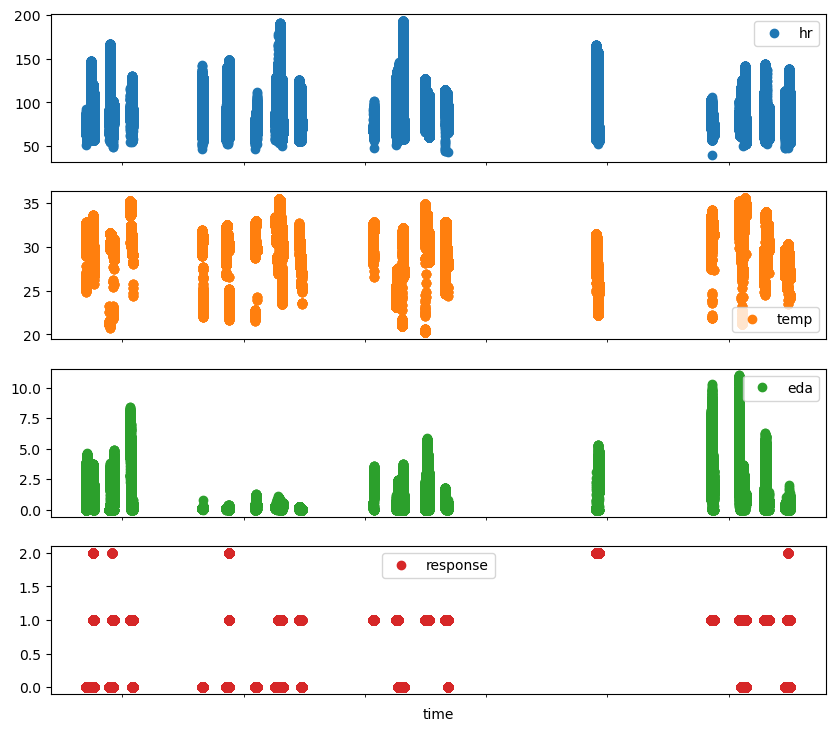

In [59]:
print(merged_df.head(200))

# Plot hr, temp, eda as lines and response as points along the time axis
merged_df.plot(x='time', y=['hr', 'temp', 'eda', 'response'], subplots=True, figsize=(10, 10), marker='o', linestyle='')